In [2]:
import numpy as np
import pandas as pd

import os
import h5py
import h5py
import numpy as np
import io
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from torchvision import transforms
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageFilter, ImageEnhance
from torchvision.transforms.functional import rgb_to_grayscale, to_pil_image
from skimage.feature import canny
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np


In [20]:
train_df = pd.read_csv("train-metadata.csv")
test_df = pd.read_csv("test-metadata.csv")
train_images_list = os.listdir('train-image/image')
INPUT_SHAPE=(224, 224, 3)
train_df = train_df[:10000]
train_df

C:\Users\gupta\AppData\Local\Temp\ipykernel_18292\2533750774.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ISIC_0320904,0,IP_8054445,55.0,male,anterior torso,5.00,TBP tile: close-up,3D: XP,14.288650,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.996950
9996,ISIC_0320911,0,IP_8041141,25.0,female,lower extremity,3.03,TBP tile: close-up,3D: white,15.996150,...,IL_1705184,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.998570
9997,ISIC_0320933,0,IP_4039962,70.0,male,upper extremity,9.37,TBP tile: close-up,3D: white,16.485939,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.922442
9998,ISIC_0320941,0,IP_2859289,30.0,male,lower extremity,10.52,TBP tile: close-up,3D: XP,22.230795,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.830651


### Feature Engineering

In [21]:
train_df['mel_mitotic_index'].unique()

array([nan], dtype=object)

In [22]:
def preprocess_image(image_path):
    # Load image using PIL
    image = Image.open(image_path).convert("RGB")
    
    # Resize to 224x224
    resize = transforms.Resize((224, 224))
    image = resize(image)
    
    # Normalize (0-1 range)
    normalize = transforms.ToTensor()  # Converts to tensor and normalizes to [0, 1]
    image = normalize(image)
    
    # Data Augmentation (milder approach)
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Reduced rotation angle
    ])
    image = augmentation(image)
    
    # Optional: Commenting out grayscale and histogram equalization steps
    # image = transforms.Grayscale(num_output_channels=1)(image)
    
    # Convert back to tensor (after augmentation)
    image_np = image.numpy().transpose(1, 2, 0)  # Convert to numpy array
    image_np = (image_np * 255).astype(np.uint8)  # Convert to uint8

    # Histogram Equalization (Optional, and milder)
    # image_np = cv2.equalizeHist(image_np)  # Only if using grayscale or one channel
    
    # Convert back to tensor
    image = torch.from_numpy(image_np.transpose(2, 0, 1) / 255.0).float()

    # Skip Gaussian Blur (as it's often too strong for sensitive features)
    
    # Cropping (Only if necessary)
    # crop = transforms.CenterCrop(200)  # Optional cropping, commented out
    # image = crop(image)

    # Normalize again (if needed, for model input)
    final_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                           std=[0.229, 0.224, 0.225])
    image = final_normalize(image)
    
    return image


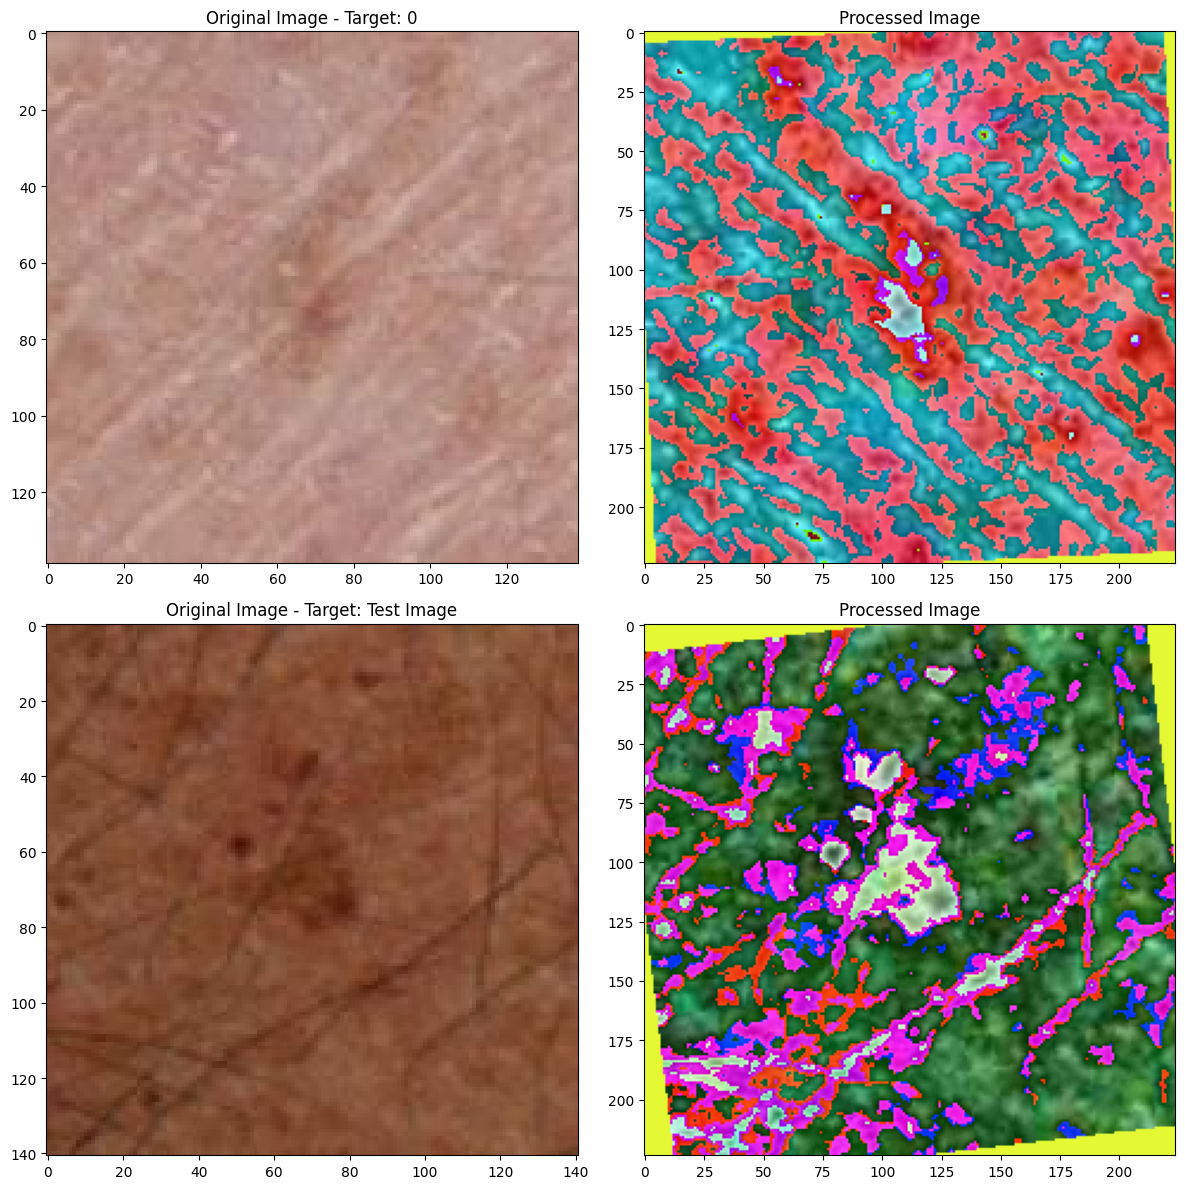

In [23]:
target_dict = train_df.set_index('isic_id')['target'].to_dict()

def process_and_display_image(image_path, subplot, target_dict = None):
    # Load the image
    image = Image.open(image_path)

    # Get the isic_id from the image_path
    if target_dict == None:
        isic_id = 'ISIC_0015657'
        target = 'Test Image'
    else:
        isic_id = image_path.split('/')[-1].split('.')[0]
        target = target_dict[isic_id]

    # Get the target from the target_dict

    # Display the original image with target
    plt.subplot(*subplot)
    plt.imshow(image)
    plt.title(f'Original Image - Target: {target}')

    # ... rest of your image processing code ...

    # Process the image
    processed_image = preprocess_image(image_path)
    
    # Convert the tensor back to a PIL Image
    processed_image_pil = transforms.ToPILImage()(processed_image)
    
    # Display the processed image
    plt.subplot(*subplot[0:2], subplot[2]+1)
    plt.imshow(processed_image_pil)
    plt.title('Processed Image')

# Get a list of all isic_ids with target 0 and target 1
isic_ids_target_0 = [isic_id for isic_id, target in target_dict.items() if target == 0]
isic_ids_target_1 = [isic_id for isic_id, target in target_dict.items() if target == 1]

# Select the first image from each list
image_path1 = f'train-image/image/{isic_ids_target_0[0]}.jpg'
image_path2 = f'train-image/image/{isic_ids_target_1[0]}.jpg'

image_path3 = 'test_image/image/ISIC_0015657.jpg'
# 'test_image\image\ISIC_0015657.jpg'
# Create a figure
plt.figure(figsize=(12, 12))

# Process and display the two images
process_and_display_image(image_path1, (2, 2, 1), target_dict)
# process_and_display_image(image_path2, (2, 2, 3), target_dict)
process_and_display_image(image_path3, (2, 2, 3))

# Show the figure
plt.tight_layout()
plt.show()


In [24]:
cols_todelete = [
    "patient_id",
    "image_type",
    "tbp_tile_type", ##
    "lesion_id",
    "iddx_full", ##
    "iddx_1", ##
    "iddx_2", ##
    "iddx_3", ##
    "iddx_4", ##
    "iddx_5", ##
    "mel_thick_mm", ## Not present in test-metadata.csv
    "tbp_lv_dnn_lesion_confidence", ## Not present in test-metadata.csv
]

cols_categorical = [
    "sex",
    "anatom_site_general",
    "tbp_lv_location",
    "tbp_lv_location_simple",
    "attribution", ##
    "copyright_license", ##
    # "mel_mitotic_index"
]

cols_numerical = [
    "isic_id",
    "mel_mitotic_index",
    "age_approx",
    "clin_size_long_diam_mm",
    "tbp_lv_A",
    "tbp_lv_Aext",
    "tbp_lv_L",
    "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA",
    "tbp_lv_deltaB",
    "tbp_lv_deltaL",
    "tbp_lv_deltaLB",
    "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border",
    "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL",
    "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis",
    "tbp_lv_symm_2axis_angle",
    "tbp_lv_x",
    "tbp_lv_y",
    "tbp_lv_z",
#     "mel_thick_mm", ## Test this in categorical as well
#     "tbp_lv_dnn_lesion_confidence"
]

cols_target = [
    "target"
]
X = train_df.fillna(0)
y = train_df[cols_target].fillna(0)
X = X[cols_numerical + cols_categorical]


# X_2 = train_df.fillna(0)
# y_2 = train_df[cols_target].fillna(0)
# X_2 = X_2[cols_numerical + cols_categorical]
# X[cols_categorical]

C:\Users\gupta\AppData\Local\Temp\ipykernel_18292\790792719.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = train_df.fillna(0)


In [26]:
from sklearn.preprocessing import LabelEncoder
for i in range(len(cols_categorical)):
    le =LabelEncoder()
    X[cols_categorical[i]] = le.fit_transform(list(X[cols_categorical[i]].values))
# X[cols_categorical]

#  **ML Model 1** (Not working) 

### Simple pytorch model with cnn and  linear with image added as array features columns

## Mode 1 feature  engineering

In [9]:
file_list = []
for _, row in X.iterrows():        
            # if row["set"]=="org":
            file_list.append(f"train-image/image/{row['isic_id']}.jpg") # = row["isic_id"]
            # else:
            #     file_list[row["isic_id"]] = f"/kaggle/input/all-isic-data-20240629/images/{row['isic_id']}.jpg"
# X['img_loc'] = file_list

In [10]:
l  = [1,2,3,4]
l = np.array(l)
l = torch.from_numpy(l)
l

tensor([1, 2, 3, 4], dtype=torch.int32)

In [11]:
def prep_image_data(df):
    img_df = []
    for _, row in df.iterrows():
        img_path = f"train-image/image/{row['isic_id']}.jpg"
        img = preprocess_image(img_path)
        img = transforms.ToPILImage()(img)
        convert_tensor = transforms.ToTensor()
        img = convert_tensor(img)
        img = torch.reshape(img, (3,224,224))
        img = img.flatten()
        img_df.append(img)
    img_df = np.array(img_df)
    img_df = torch.from_numpy(img_df)
    return img_df

In [12]:
img_array = prep_image_data(X)

X = X.drop(['isic_id'],axis=1)
X = X.iloc[:,:].values
y = y.values
X =  torch.from_numpy(X)
y =  torch.from_numpy(y)


In [13]:

X = torch.cat((X,img_array) , axis=1)

In [14]:
X_train, X_test = X[:round(0.8*len(X))], X[round(0.8*len(X)):]
y_train, y_test = y[:round(0.8*len(y))], y[round(0.8*len(y)):]

In [15]:
X_train.shape

torch.Size([400, 150563])

In [16]:
X_train[0,35:].shape

torch.Size([150528])

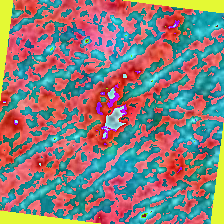

In [17]:
ii = torch.reshape(X_train[0,35:], (3,224,224))
transform = transforms.ToPILImage()
img = transform(ii)
# img = Image.open(img)
# img.show()
img

In [39]:
X_train[:,35:].shape

torch.Size([400, 150528])

## ML Model 1

In [19]:
import torch
import torch.nn as nn
import keras
from keras import layers
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import imageio as iio
from torchvision import transforms
from PIL import Image
IMG_SIZE = 224

In [20]:
# model = keras.models.Sequential([
# 	layers.Conv2D(filters=32,
# 				kernel_size=(5, 5),
# 				activation='relu',
# 				input_shape=(IMG_SIZE,
# 							IMG_SIZE,
# 							3),
# 				padding='same'),
# 	layers.MaxPooling2D(2, 2),

# 	layers.Conv2D(filters=64,
# 				kernel_size=(3, 3),
# 				activation='relu',
# 				padding='same'),
# 	layers.MaxPooling2D(2, 2),

# 	layers.Conv2D(filters=128,
# 				kernel_size=(3, 3),
# 				activation='relu',
# 				padding='same'),
# 	layers.MaxPooling2D(2, 2),

# 	layers.Flatten(),
# 	layers.Dense(256, activation='relu')
# ])
# model.summary()


In [48]:
!pip install torchsummary

In [53]:
from torchsummary import summary

class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.image_processing = nn.Sequential(
				Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), padding='same'), 
				ReLU(),
				MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
				Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same'), 
				ReLU(),
				MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
				Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same'), 
				ReLU(),
				MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
				nn.Flatten(),
				nn.Linear(in_features=86528, out_features=1000)
		)
        self.add_layer = nn.Sequential(
                nn.Linear(in_features=1036, out_features=512),
                nn.Linear(in_features=512, out_features=100),
                nn.Linear(in_features=100, out_features=1)
		)     
    def reshape_img(self, x):
        print(x.shape)
        # expected_size = 400*3 * 224 * 224
        # if x.numel() == expected_size:
        return torch.reshape(x, (400, 3, 224, 224))
        # else:
            # raise ValueError(f"Input size {x.numel()} is not compatible with the target shape (3, 224, 224). Expected {expected_size} elements.")

    
    def forward(self, x):
        img_data = self.reshape_img(x[:,35:])
        linear_data = x[:,:35]
        print(img_data.shape)
        x_1 = self.image_processing(img_data)
        x = self.add_layer(linear_data + x_1)
        y = torch.round(x)
        return y
              

model = MyModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                              lr = 1e-4)
# summary(model, input_size=(400,3,224,224))

torch.Size([2, 365, 3, 224, 224])


RuntimeError: shape '[400, 3, 224, 224]' is invalid for input of size 109885440

In [45]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

  model.train()
  print(X_train.shape)
  y_preds = model(X_train)

  loss = loss_fn(y_preds , y_train)
  acc = accuracy_score(y_true = y_train,
                 y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward() # does back propogation

  optimizer.step() # updates the parameters with the helpof gradient descent

  model.eval()

  with torch.inference_mode():
    test_pred = model(X_test)

    test_loss = loss_fn(test_pred,
                        y_test)
    test_acc = accuracy_score(y_true=y_test,
                        y_pred = test_pred)

    
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

torch.Size([400, 150563])
torch.Size([400, 150528])
torch.Size([400, 3, 224, 224])


RuntimeError: expected scalar type Double but found Float

In [ ]:
# data=[]
# def data_create(id , df , img_folder):
#     csv_features = df.loc[df['isic_id']==id].values[:,1:]
#     csv_features = csv_features.squeeze()
#     # print(csv_features.shape)
#     img_add = str(id) + '.jpg'
#     # print(csv_features)
#     img = load_img( img_folder + img_add , target_size=(224,224,3))
#     img = img_to_array(img)
#     img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
#     img = preprocess_input(img)
#     # print(img.shape)
#     image_features = model.predict(img , verbose=0)
#     # print(image_features.shape)
#     image_features = image_features.squeeze().tolist()
#     data.append( np.concatenate((csv_features,image_features)).tolist() )


# for i in range(len(X)):
#     data_create(train_df['isic_id'][i], X, 'train-image/image/')


# **ML Model 2**

### Pre-encoding image and then adding in the featuer array

In [ ]:
# !pip install pytorch_pretrained_vit

In [27]:
import json
from PIL import Image
import torch
from torchvision import transforms

# Load ViT
from pytorch_pretrained_vit import ViT
model = ViT('B_16_imagenet1k', pretrained=True, image_size=224)
model.eval()


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 197, 768])
Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [11]:
outputs = []
file_list = []
for _, row in X.iterrows():        
            # if row["set"]=="org":
            file_list.append(f"train-image/image/{row['isic_id']}.jpg") # = row["isic_id"]
            # else:
            #     file_list[row["isic_id"]] = f"/kaggle/input/all-isic-data-20240629/images/{row['isic_id']}.jpg"
# X['img_loc'] = file_list
for i in file_list:    
    img = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])(Image.open(f'{i}')).unsqueeze(0)
    # print(img.shape) # torch.Size([1, 3, 224, 224])

    # Classify
    with torch.no_grad():
        output = model(img)
        outputs.append(output.squeeze())
print(len(outputs))  # (1, 1000)

10000


In [28]:
outputs = np.array(outputs)
outputs = torch.from_numpy(outputs)
outputs.shape

torch.Size([10000, 1000])

In [29]:
X = X.drop(['isic_id'], axis=1)
X = X.iloc[:,:].values


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [30]:
X = torch.from_numpy(X)
X = torch.cat((X,outputs) , axis=1)


tensor([[ 0.0000, 60.0000,  3.0400,  ...,  1.3740,  1.2623, -0.2065],
        [ 0.0000, 60.0000,  1.1000,  ...,  1.5673,  2.2014, -1.1991],
        [ 0.0000, 60.0000,  3.4000,  ...,  1.4429,  1.6273, -0.1190],
        ...,
        [ 0.0000, 70.0000,  9.3700,  ..., -1.3845,  0.4515,  3.3348],
        [ 0.0000, 30.0000, 10.5200,  ...,  1.0449,  0.3593, -0.9222],
        [ 0.0000, 75.0000,  2.5600,  ...,  2.6073,  1.4947, -0.3326]],
       dtype=torch.float64)

In [31]:
X.shape

torch.Size([10000, 1035])

In [33]:
y_train.shape

(8000, 1)

In [34]:
X_train.shape

torch.Size([8000, 1035])

In [35]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    num_class=1,      
    # max_depth=max_depth,       
    # learning_rate=learning_rate,
    # subsample=subsample,        
    # colsample_bytree=colsample, 
    n_estimators=1000
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=1,
              num_parallel_tree=None, ...)

In [36]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9985